### Ghost Storage 

## Source of Standard Ghosts

###  Prompt
````

Floating Ghost in a Victorian house in New Jersey .  Creepy and realistic 35mm film

Floating Ghost Modern New York. Creepy Surreal at an unstructured data meetup

````

### Resources

* https://aitestkitchen.withgoogle.com/tools/image-fx?

* https://unsplash.com/s/photos/ghost?license=free

* My own pictures

* https://ghostbusters.fandom.com/wiki/Tobin%27s_Spirit_Guide

* https://zilliz.com/learn/build-multimodal-rag-gemini-bge-m3-milvus-langchain
* https://zilliz.com/learn/bge-m3-and-splade-two-machine-learning-models-for-generating-sparse-embeddings
* https://zilliz.com/learn/Exploring-BGE-M3-the-future-of-information-retrieval-with-milvus
* https://www.kaggle.com/code/deniskuria/notebook1e4c44ebed
* https://milvus.io/docs/embed-with-bgm-m3.md
* https://huggingface.co/BAAI/bge-m3
* https://github.com/milvus-io/pymilvus/blob/master/examples/hello_hybrid_sparse_dense.py
* https://zilliz.com/ai-models/gte-base-en-v1.5

In [11]:
import os
from dotenv import load_dotenv
load_dotenv(override=True)

True

In [12]:
from tqdm.notebook import tqdm
from PIL import Image
from sentence_transformers import SentenceTransformer
from pymilvus import MilvusClient
import requests
from pymilvus import (
   utility,
   FieldSchema, CollectionSchema, DataType,
   Collection, AnnSearchRequest, RRFRanker, connections,
)
from pymilvus.model.dense import SentenceTransformerEmbeddingFunction
from pymilvus.model.sparse import SpladeEmbeddingFunction
from pymilvus.model.hybrid import BGEM3EmbeddingFunction

# Multi
bge_m3 = BGEM3EmbeddingFunction(
    model_name = 'BAAI/bge-m3', 
    device = 'cpu', 
    use_fp16 = False
)

# BGE-M3 Sparse
dense_dim = bge_m3.dim["dense"] 

# Slade Sparse
splade_ef = SpladeEmbeddingFunction(
    model_name="naver/splade-cocondenser-selfdistil", 
    device="cpu"
)

# Load CLIP model
model = SentenceTransformer('clip-ViT-B-32')

# Big Text
textmodel = SentenceTransformer("Alibaba-NLP/gte-base-en-v1.5", trust_remote_code=True)

Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

/Users/timothyspann/miniforge3/envs/hybridsearch/lib/python3.10/site-packages/FlagEmbedding/BGE_M3/modeling.py:335: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  colbert_sta

In [14]:
import time
import datetime
from time import gmtime, strftime
import random, string
import uuid

from faker import Faker
from faker.providers import internet, address, automotive, barcode, company, date_time, geo, job, misc, person
from faker.providers import phone_number, user_agent, emoji
import json

fake = Faker()
fake.add_provider(internet)
fake.add_provider(address)
fake.add_provider(automotive)
fake.add_provider(barcode)
fake.add_provider(company)
fake.add_provider(emoji)
fake.add_provider(date_time)
fake.add_provider(geo)
fake.add_provider(job)
fake.add_provider(misc)
fake.add_provider(person)
fake.add_provider(phone_number)
fake.add_provider(user_agent)

categories = ["Ghost", "Deity", "Unstable", "Environmental", "Vathek", "Legend", "Video Game"]

In [15]:
# Connect to Milvus Standalone on Docker
from pymilvus import connections
from pymilvus import utility
from pymilvus import FieldSchema, CollectionSchema, DataType, Collection
from pymilvus import MilvusClient

### Constants
S3_URL = "http://192.168.1.166:9000"
MINIO_USER = 'minioadmin'
MINIO_PASSWORD = 'minioadmin'
MINIO_REGION = 'us-east-1'

MILVUS_URL = "http://192.168.1.166:19530" 

milvus_client = MilvusClient(uri=MILVUS_URL)
DIMENSION = 512
TEXTDIMENSION = 768
COLLECTION = "ghosts"

ghost_classes = ["Fake", "Art", "TV", "Unclassified", "Class I", "Class II", "Class III", "Class IV", "Class V", "Class VI", "Class VII"]

connections.connect(uri=MILVUS_URL )

fields = [
    FieldSchema(name='id', dtype=DataType.INT64, is_primary=True, auto_id=True),
    FieldSchema(name='ghostclass', dtype=DataType.VARCHAR, max_length=20),
    FieldSchema(name='filename', dtype=DataType.VARCHAR, max_length=256),
    FieldSchema(name='s3path', dtype=DataType.VARCHAR, max_length=1024),
    FieldSchema(name='description', dtype=DataType.VARCHAR, max_length=65000),
    FieldSchema(name='category', dtype=DataType.VARCHAR, max_length=256), 
    FieldSchema(name='identification', dtype=DataType.VARCHAR, max_length=50),  
    FieldSchema(name='location', dtype=DataType.VARCHAR, max_length=256),  
    FieldSchema(name='country', dtype=DataType.VARCHAR, max_length=4),
    FieldSchema(name='latitude', dtype=DataType.VARCHAR, max_length=20),
    FieldSchema(name='longitude', dtype=DataType.VARCHAR, max_length=20),      
    FieldSchema(name='zipcode', dtype=DataType.VARCHAR, max_length=20),  
    FieldSchema(name='timestamp', dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name='s3timestamp', dtype=DataType.VARCHAR, max_length=128),
    FieldSchema(name='vector', dtype=DataType.FLOAT_VECTOR, dim=DIMENSION),
    FieldSchema(name="text_vector", dtype=DataType.SPARSE_FLOAT_VECTOR),
    FieldSchema(name="text_vector2", dtype=DataType.FLOAT_VECTOR, dim=TEXTDIMENSION),
    FieldSchema(name="text_vector3", dtype=DataType.FLOAT_VECTOR, dim=dense_dim)
]

# with partitioning
schema = CollectionSchema(fields=fields, partition_key_field="ghostclass", num_partitions=8 )

if milvus_client.has_collection(collection_name=COLLECTION):
    print(COLLECTION + " exists")
else:
    milvus_client.create_collection(COLLECTION, schema=schema,  auto_id=True)

    index_params = milvus_client.prepare_index_params()
    
    index_params.add_index(field_name = "id", index_type="STL_SORT")
    index_params.add_index(field_name = "ghostclass", index_type="TRIE")
    index_params.add_index(field_name = "zipcode",  index_type="INVERTED", index_name="inverted_index")
    index_params.add_index(field_name = "vector", metric_type="COSINE")
    index_params.add_index(field_name = "text_vector", index_type="SPARSE_INVERTED_INDEX", metric_type="IP")
    index_params.add_index(field_name = "text_vector2", metric_type="COSINE")
    index_params.add_index(field_name = "text_vector3", metric_type= "L2", index_type="IVF_FLAT", params = {"nlist": 128} )

    milvus_client.create_index( collection_name=COLLECTION, index_params=index_params)
    
    res = milvus_client.get_load_state( collection_name = COLLECTION)
    
    print(res)

milvus_client.load_collection(COLLECTION)
res = milvus_client.get_load_state( collection_name = COLLECTION )
print(res)

### for hybrid search
collection = Collection(name=COLLECTION, schema=schema)

{'state': <LoadState: NotLoad>}
{'state': <LoadState: Loaded>}


In [16]:
import os
import boto3
from botocore.client import Config
import ollama
import random
from datetime import datetime
import pprint
import time

GHOST_BUCKET = "images"
GHOST_DIR = "/Users/timothyspann/Desktop/standardghosts" 

### full load
loadt0 = time.time()

### where to upload file
s3_client = boto3.client('s3',endpoint_url=S3_URL,config=boto3.session.Config(signature_version='s3v4'))

### list of images
image_urls = []
s3timestamps = []
filenames = []
descr = []
images = []

### iterate file system
for filename in os.listdir(GHOST_DIR):
    f = os.path.join(GHOST_DIR, filename)
    
    if os.path.isfile(f):
        if ( filename.endswith(".jpg") or filename.endswith(".png") ):
            t0 = time.time()
            filenames.append(filename)
            image_urls.append(str(S3_URL) + "/images/" + str(filename))
            s3timestamps.append(str(datetime.now()))
            s3_client.upload_file(f, GHOST_BUCKET, filename)
            images.append( Image.open(f) )
            
            try:
                response = ollama.chat(model="llava:7b",messages=[{'role': 'user',
                                       'content': 'Describe this image:','images': [str(f)]}])

#               response = ollama.chat(model='mistral-nemo', messages=[{'role': 'user','content': str(f) + 
#                ' Describe this image'}])            
                descr.append( str( response['message']['content'] ) )
            except Exception as e:
                descr.append("Standard Ghost")
                print("ollama chat exception: ")
                print(e)
            t1 = time.time()
            print(f"file: {filename} with gen time: {round(t1-t0, 4)} seconds")
    
### load images and run embedding model
image_embeddings = model.encode(images)

### iterate
for description, image_url, embedding, s3timestamp, filename in zip(descr, image_urls, image_embeddings, s3timestamps, filenames):
    try:
        category = str(random.choice(categories))
        identification = str(fake.ean13())
        location = str(fake.address())
        zipcode = str(fake.postcode())
        latitude = str(fake.latitude())
        longitude = str(fake.longitude())
        ghostclass= str(random.choice(ghost_classes))

        text_embedding = textmodel.encode(description) 
        sparse_embedding = splade_ef.encode_documents([description])
        bgem3_embedding = bge_m3.encode_documents([description])
   
        milvus_client.insert(COLLECTION, {"ghostclass": str(ghostclass),
                                          "filename": str(filename),
                                          "s3path": str(image_url),
                                          "description": str(description), 
                                          "category": category,
                                          "identification":  str(identification),
                                          "location": str(location),
                                          "country": "USA",
                                          "latitude": str(latitude),
                                          "longitude": str(longitude),
                                          "zipcode":str(zipcode),
                                          "timestamp": str(s3timestamp),
                                          "s3timestamp": str(s3timestamp),
                                          "vector": embedding, 
                                          "text_vector": sparse_embedding, 
                                          "text_vector2": text_embedding, 
                                          "text_vector3": bgem3_embedding["dense"][0]} )
    except Exception as e:
        print("save exception: ")
        print(e)

### full load stop
loadt1 = time.time()

print(f"Inserted Time: {round(loadt1-loadt0, 4)} seconds\n\n")
print("Inserted " + str(len(filenames)) + " rows.")

file: meetup2.jpg with gen time: 14.8265 seconds
file: milvuswalk.jpg with gen time: 10.2944 seconds
file: kym-mackinnon-eQqcz7NWyH4-unsplash.jpg with gen time: 7.4018 seconds
file: v8.jpg with gen time: 7.1121 seconds
file: meetup3.jpg with gen time: 8.4391 seconds
file: meetup1.jpg with gen time: 6.6762 seconds
file: victorian800.jpg with gen time: 10.3376 seconds
file: meetup4.jpg with gen time: 9.0756 seconds
file: nik-ZYUA63_rqcI-unsplash.jpg with gen time: 10.906 seconds
file: darkghost.jpg with gen time: 8.1983 seconds
file: spaceangel.jpg with gen time: 10.1658 seconds
file: meetup5.jpg with gen time: 8.2793 seconds
file: patrick-tomasso-SDA-pOBbNdY-unsplash.jpg with gen time: 12.4204 seconds
file: victorian999.jpg with gen time: 7.2224 seconds
file: glowghost.jpg with gen time: 8.5358 seconds
file: meetup6.jpg with gen time: 8.7801 seconds
file: victorian900.jpg with gen time: 10.056 seconds
file: kevin-escate-4Se7r4gf6KE-unsplash.jpg with gen time: 12.3011 seconds
file: victo

Ghost: Class II http://192.168.1.166:9000/images/v6.jpg  0.2944015562534332
Ghost: Class I http://192.168.1.166:9000/images/victorian600.jpg  0.2878371775150299
Ghost: Class II http://192.168.1.166:9000/images/ghost100.jpg  0.28580063581466675
Ghost: Class I http://192.168.1.166:9000/images/ghost4.jpg  0.2829335033893585
Ghost: Class VII http://192.168.1.166:9000/images/victorian500.jpg  0.2801421880722046
Ghost: Class II http://192.168.1.166:9000/images/ghost400.jpg  0.27868035435676575
Ghost: Class IV http://192.168.1.166:9000/images/v5.jpg  0.27577972412109375
Ghost: Class I http://192.168.1.166:9000/images/janko-ferlic-T43tMZ5jyzs-unsplash.jpg  0.27359309792518616
Ghost: Class III http://192.168.1.166:9000/images/v2.jpg  0.27199217677116394
Ghost: Class I http://192.168.1.166:9000/images/glowghost.jpg  0.27191391587257385


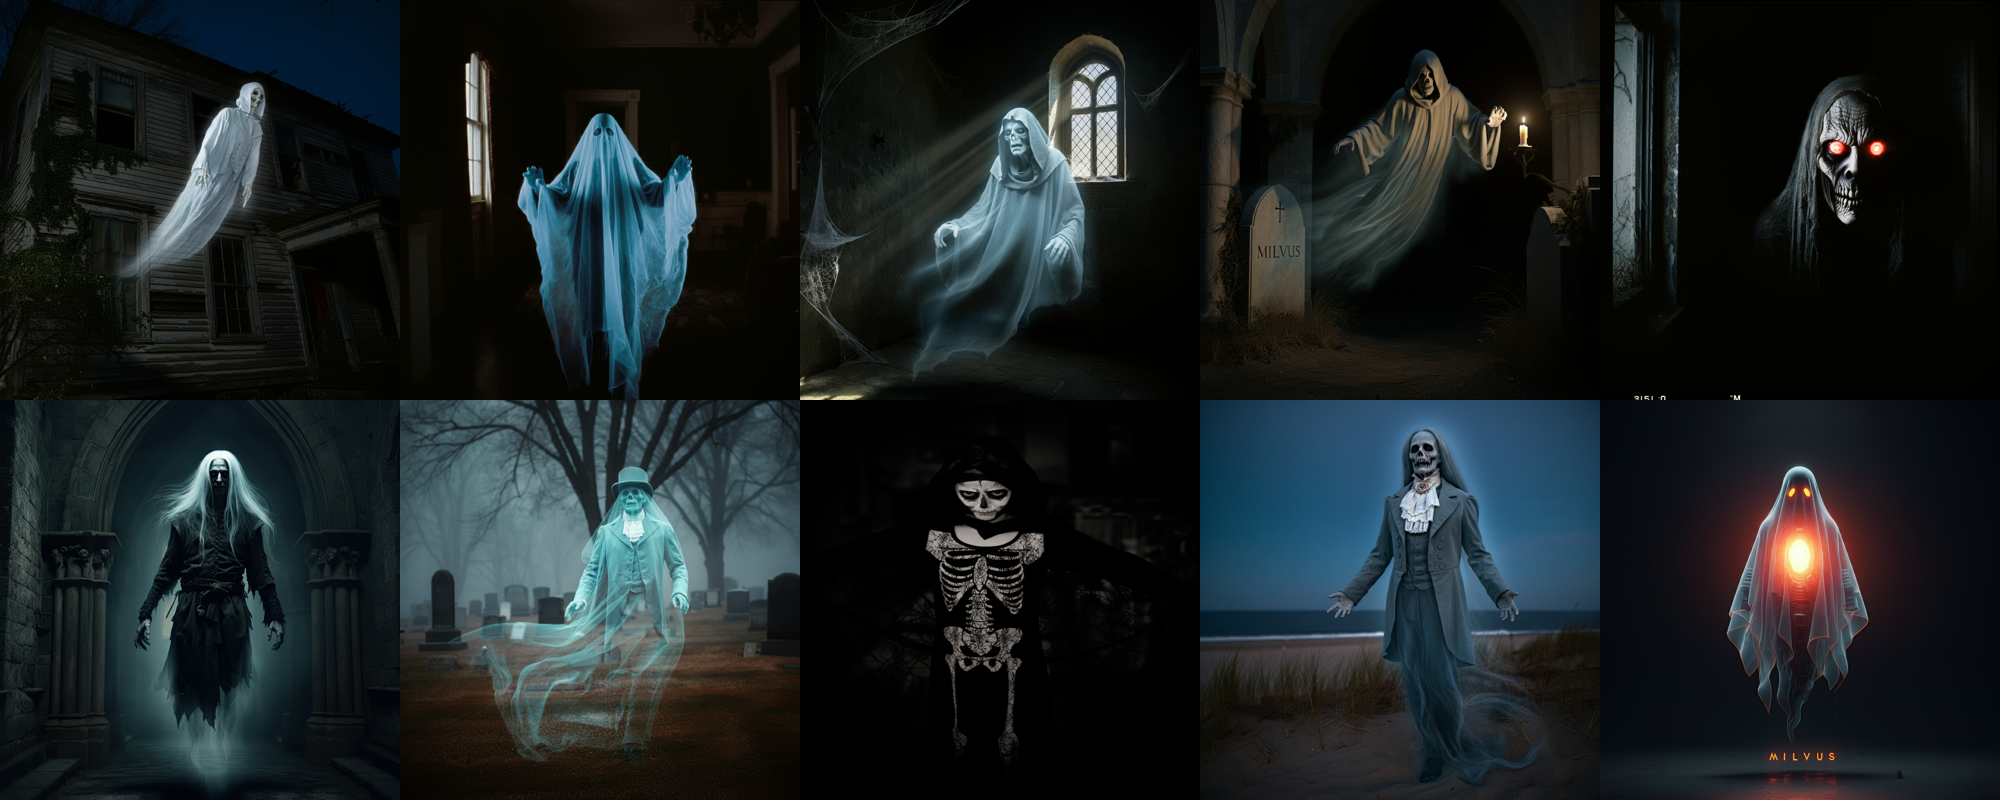

In [18]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO

text_query = str("ghost with a skull head")

# Generate text embeddings
queries = [text_query]
query_embeddings = model.encode(queries)

# search for ghosts
results = milvus_client.search(
    collection_name=COLLECTION,
    data=query_embeddings,
    consistency_level="Eventually", 
    filter='ghostclass in ["Class I", "Class II", "Class III", "Class IV", "Class V", "Class VII"]',
    anns_field = "vector",
    limit = 10,
    output_fields=["s3path", "ghostclass"])

images = []
for result in results:
    for hit in result[:10]:
        s3path = hit["entity"]["s3path"]
        if ( s3path != None ):
            response = requests.get(s3path)
            img = Image.open(BytesIO(response.content))
            img = img.resize((400, 400))
            images.append(img)
            # img = img.resize((250, 250))
            # display(img)
            print("Ghost: " + str(hit["entity"]["ghostclass"]) + " " + str(s3path) + "  " + str(hit["distance"])  )

width = 400 * 5
height = 400 * 2
concatenated_image = Image.new("RGB", (width, height))

for idx, img in enumerate(images):
    x = idx % 5
    y = idx // 5
    concatenated_image.paste(img, (x * 400, y * 400))

display(concatenated_image)
concatenated_image.save("results.jpg", "JPEG")

Similiar to an existing ghost


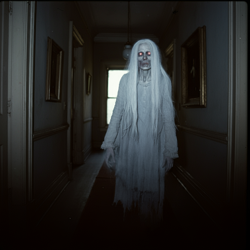

Ghost Class: Unclassified http://192.168.1.166:9000/images/victorian200.jpg Distance: 0.8716338276863098



In [19]:
from IPython.display import display
from PIL import Image
import requests
from io import BytesIO

IS_GHOST_CONSTANT = float(0.9)

# IS_THIS_A_GHOST = "/Users/timothyspann/Desktop/imagesearch/catandskull.png" # <---  not a ghost
IS_THIS_A_GHOST = "/Users/timothyspann/Desktop/imagesearch/cryptwalker.jpg" # <--- this is a ghost
# IS_THIS_A_GHOST = "/Users/timothyspann/Desktop/imagesearch/ghost2.jpg"  # <-- already loaded

img_query = Image.open(IS_THIS_A_GHOST)

# Generate image embeddings
queries = [img_query]
query_embeddings = model.encode(queries)

# search for ghosts
results = milvus_client.search(
    collection_name=COLLECTION,
    data=query_embeddings,
    consistency_level="Eventually", 
    anns_field = "vector",
    limit = 1,
    output_fields=["s3path", "ghostclass"])

# Convert the output to a formatted JSON string
# result = json.dumps(results, indent=4)
# print(result)

for result in results:
    for hit in result[:1]:
        # https://milvus.io/docs/metric.md?tab=floating
        
        if ( float(hit["distance"]) > 0.8 ):
            print("Similiar to an existing ghost")
            s3path = hit["entity"]["s3path"]
            if ( s3path != None ):
                response = requests.get(s3path)
                img = Image.open(BytesIO(response.content))
                img = img.resize((250, 250))
                display(img)
                print("Ghost Class: " + str(hit["entity"]["ghostclass"] + " " + str(s3path) + " Distance: " + str(hit["distance"]) ) + "\n")
        else:
            print( "\n\nThis kind of looks like a ghost but only the similiarity is " + str( round(float(hit["distance"])*100,2)) + "%")



In [21]:
from pymilvus import AnnSearchRequest, RRFRanker, WeightedRanker
import time
from pymilvus import WeightedRanker

# Use WeightedRanker to combine results with specified weights
rerank = WeightedRanker(0.6, 0.7, 0.8, 0.9 , 0.6) 
QUERY = str("creepy skull head ghost")

queries = [QUERY]
query_embeddings = model.encode(queries)

search_param_0 = {
    "data": query_embeddings, 
    "anns_field": "vector", 
    "param": {"metric_type": "COSINE", },"limit": 3 }

request_0 = AnnSearchRequest(**search_param_0)

search_param_1 = {
    "data": textmodel.encode([QUERY]),
    "anns_field": "text_vector2", 
    "param": {
        "metric_type": "COSINE", 
    },    "limit": 3 }

request_1 = AnnSearchRequest(**search_param_1)

search_param_2 = {
    "data": splade_ef.encode_queries([QUERY]), 
    "anns_field": "text_vector", 
    "param": {
        "metric_type": "IP", 
    }, "limit": 3}

request_2 = AnnSearchRequest(**search_param_2)

images = Image.open(requests.get("http://192.168.1.166:9000/images/ghost4.jpg", stream=True).raw) 
image_embeddings = model.encode([images])

search_param_3 = {
    "data": image_embeddings, 
    "anns_field": "vector", 
    "param": {
        "metric_type": "COSINE", 
    },"limit": 3 }

request_3 = AnnSearchRequest(**search_param_3)

bgem3_queries = bge_m3.encode_queries([QUERY])

search_param_4 = {
    "data": bgem3_queries["dense"],
    "anns_field": "text_vector3", 
    "param": {
        "metric_type": "L2", 
    },"limit": 3 }

request_4 = AnnSearchRequest(**search_param_4)

reqs = [request_0, request_1, request_2, request_3, request_4]

collection.load()

# Run a start and end time for our search
# Search collection vector from above
t0 = time.time()

results = collection.hybrid_search(reqs,  rerank, 
                                   output_fields=["s3path",  "timestamp", "ghostclass", "location"],
                                   limit=10)

t1 = time.time()
print(f"search latency: {round(t1-t0, 4)} seconds\n\n")


search latency: 0.071 seconds




Distance: 2.5591976642608643 ID:453043247072627301 URL: http://192.168.1.166:9000/images/ghost4.jpg Time: 2024-10-13 00:53:20.624048


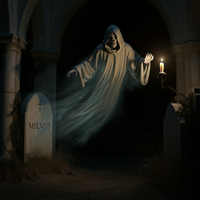

Distance: 0.9191666841506958 ID:453043247072627261 URL: http://192.168.1.166:9000/images/victorian500.jpg Time: 2024-10-13 00:50:10.100322


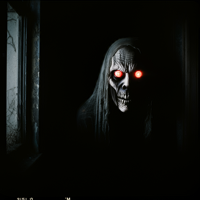

Distance: 0.8621681928634644 ID:453043247072627241 URL: http://192.168.1.166:9000/images/glowghost.jpg Time: 2024-10-13 00:48:34.585108


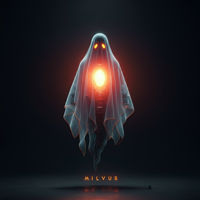

In [22]:
# -----------------------------------------------------------------------------
# Iterate through last <limit> results and display scalars
# -----------------------------------------------------------------------------
for result in results:
    for row in result[:3]:
        filepath = row.entity.s3path
        print( "Distance: " + str(row.distance) + " ID:" + str(row.id)  +
               " URL: " + str(filepath) + " Time: " + str(row.entity.timestamp) )
        
        response = requests.get(filepath)
        img = Image.open(BytesIO(response.content))
        img = img.resize((200, 200))
        display(img)



### Class III  -  Ghost


#### Location 
414 Lauren Orchard
New Aaronland, TN 67375 11097 USA (-83.1626795, 151.725579)

#### Sighting Time 
2024-10-13 00:48:27.360861

---

 This is a staged photograph that depicts a ghostly figure standing on the lower step of a staircase, which appears to be inside an old Victorian house. The figure, wearing a white dress and a hooded cloak, stands looking upwards, with its head turned to the side as if observing something. The room is dimly lit by natural light coming in from a window located on the wall behind the stairs. The atmosphere of the image suggests a supernatural or horror theme, commonly associated with ghost stories and films. 

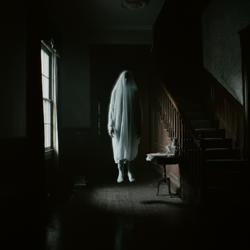



<br/>



### Class VII  -  Environmental


#### Location 
689 Gina River
Williamsmouth, PW 72200 81814 USA (13.8551065, -17.054532)

#### Sighting Time 
2024-10-13 00:50:44.958039

---

 The image is a dark, moody photograph depicting a classic Victorian mansion at night. The house has prominent features such as a tower and several gables, suggesting an architectural style reminiscent of the late 19th century. In front of the house, there is a large moon in the sky casting a bright glow. A supernatural element present in the image is a floating ghost or apparition positioned above the house. This figure appears to be gazing downward toward the mansion below, with its body obscured by fog or mist. The overall atmosphere of the image conveys a sense of eeriness and supernatural presence. 

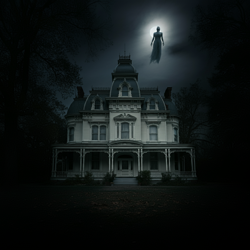



<br/>



### Class III  -  Vathek


#### Location 
5359 Rhodes Overpass
Caitlintown, MT 74452 89802 USA (28.9332035, -94.451655)

#### Sighting Time 
2024-10-13 00:51:51.928629

---

 This image features a person dressed in a historical or Victorian style, posing on a beach at night. The individual is wearing a suit with a white shirt and bow tie, a black top hat, and a long coat that extends to the ground. They also have a ruffled collar around their neck and are holding onto what appears to be a small cloud of smoke or mist, which seems to be emanating from them.

The person is standing with their arms outstretched, as if they are embracing the moment or perhaps offering a wave goodbye. Their face is obscured by a skull mask that has intricate details and appears to have a glow or light emanating from it. The background is dark, suggesting it is nighttime, and there's a vast expanse of a sandy beach leading to the ocean in the distance. There are no visible texts or distinguishing brands in the image. 

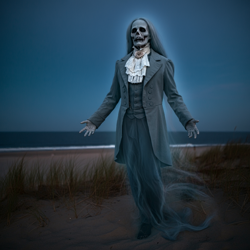



<br/>



### Class III  -  Unstable


#### Location 
Unit 3466 Box 3026
DPO AA 28853 23361 USA (-51.0151465, 43.406578)

#### Sighting Time 
2024-10-13 00:52:36.443411

---

 In the given image, a person is standing in the center of a graveyard. They are dressed in an old-fashioned black dress with ruffles, and a top hat adorns their head. The person has light skin, dark hair, and is wearing dark makeup that accentuates their eyes and lips. 

The individual appears to be embodying the spirit of Victorian or Gothic fashion, which gives them an eerie and mysterious appearance. They have one hand extended upwards as if reaching for something or making a gesture, and the other hand is resting by their side. Their feet are firmly planted on the ground.

In the background, there is a large, gnarled tree with bare branches that suggest it might be autumn or winter. The graveyard is filled with tombstones of various shapes and sizes, some closer to the person in the foreground, while others further away. 

The atmosphere of the image is quite moody and atmospheric, enhanced by the foggy weather conditions that shroud the scene. This creates a sense of mystery and perhaps a hint at supernatural activities, as the figure's pose and attire evoke the spirit of a ghost or witch from folklore or popular culture. 

Overall, the image captures a moment of quiet stillness in an otherwise desolate graveyard, with a focus on the central figure who stands out against the foggy backdrop. The use of color is minimalistic, using black and white to emphasize the contrast between the foreground and background elements. 

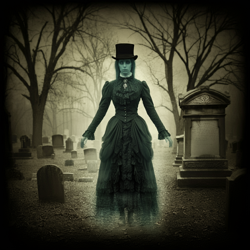



<br/>



### Class IV  -  Deity


#### Location 
3583 April Bridge
Chavezton, WY 84711 37458 USA (-7.567219, 56.627164)

#### Sighting Time 
2024-10-13 00:53:00.453793

---

 The image is a photograph with a sepia tone that evokes a vintage or historical feel. It features an outdoor setting with trees in the background. In the foreground, there's a ghostly figure standing on a grassy area. This figure is adorned with elaborate clothing and accessories resembling those of a classical Victorian style. The individual appears to be dressed as a male figure from the past, complete with a suit, top hat, and a cane.

The person is draped in a large, ethereal, flowing white garment that suggests a ghostly or supernatural theme. This attire creates a dramatic contrast against the darker tones of the setting. The individual has long hair and seems to be looking towards the camera with an expression that could be interpreted as contemplative or solemn.

The style of the image, including the clothing and posture of the central figure, suggests it may be staged for artistic purposes rather than depicting a real event. The overall mood of the image is one of melancholy or nostalgia, amplified by the foggy atmosphere and the solitary figure's pose. 

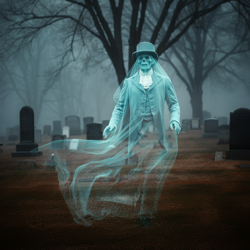



<br/>

In [23]:
from IPython.display import display, Markdown

### Simple Queries Report

query_results = milvus_client.query(
    collection_name=COLLECTION,
    filter='description like "%Victorian%"',
    output_fields=["timestamp", "ghostclass","description","category", "s3path","location","zipcode","country","latitude","longitude"], 
    limit=5
)

for result in query_results:
    display(Markdown("\n\n### " + str(result['ghostclass']) + "  -  " + str(result['category'] ) + "\n"))
    display(Markdown("#### Location \n" + str(result['location']) + " " + 
                     str(result['zipcode']) + " " + str(result['country']) + 
                     " (" + str(result['latitude']) + ", " + str(result['longitude']) + ")" ))
    display(Markdown("#### Sighting Time \n" + str(result['timestamp'])))
    display(Markdown("---"))
    display(Markdown(result['description']))

    response = requests.get(result['s3path'])
    img = Image.open(BytesIO(response.content))
    img = img.resize((250, 250))
    display(img)
    display(Markdown("\n\n<br/>"))